# NEURAL NETWORKS AND DEEP LEARNING

---
A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---

# HOMEWORK 3 - Deep Reinforcement Learning - Notebook 1/2

**FRANCESCO FONTANA -  matricola 2026924**

(Modification of LAB 7 notebook)

In [ ]:
!pip install gym

In [ ]:
import random
import torch
import numpy as np
import gym
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from torch import nn
from collections import deque # this python module implements exactly what we need for the replay memeory

# Enable gym environment rendering in Colab

> This section is not required if you are executing the notebook in a local environment. It enables the video generation from Gym environments, and it is only required in Colab since we do not have access to a screen.

Source: https://colab.research.google.com/drive/18LdlDDT87eb8cCTHZsXyS9ksQPzL3i6H

In [ ]:
!apt -qq update
!apt-get -qq install python-opengl -y
!apt -qq install xvfb -y --quiet
!pip install pyvirtualdisplay --quiet
!pip install piglet --quiet

W: GPG error: https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease: The following signatures couldn't be verified because the public key is not available: NO_PUBKEY A4B469963BF863CC
E: The repository 'https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease' is no longer signed.


In [ ]:
import glob
import io
import base64
import os
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import Monitor

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_videos():
  mp4list = glob.glob('video/*.mp4')
  mp4list.sort()
  for mp4 in mp4list:
    print(f"\nSHOWING VIDEO {mp4}")
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    
def wrap_env(env, video_callable=None):
  env = Monitor(env, './video', force=True, video_callable=video_callable)
  return env

# Experience replay (Replay Memory)

"*To perform experience replay, we store the agent's experiences e_t=(s_t,a_t,r_t,s_t+1) at each time-step t in a data set D_t={e_1,…,e_t}. During learning, we apply Q-learning updates, on samples (or mini-batches) of experience (s,a,r,s′)∼U(D), drawn uniformly at random from the pool of stored samples.*"

Source: https://www.nature.com/articles/nature14236

In practice, what we need is a queue with a predefined capacity. When we reach the maximum capacity, the oldest element in the queue will be replaced with the new one.

This exact behavior is implemented by the `deque` object from the python `collections` library (https://docs.python.org/3/library/collections.html#collections.deque):

"*If maxlen is not specified or is None, deques may grow to an arbitrary length. Otherwise, the deque is bounded to the specified maximum length. Once a bounded length deque is full, when new items are added, a corresponding number of items are discarded from the opposite end.*"

The random sampling can be easily achieved using the `random.sample` method (https://docs.python.org/3/library/random.html). 

In [ ]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity) # Define a queue with maxlen "capacity"

    def push(self, state, action, next_state, reward):
        self.memory.append((state, action, next_state, reward))

    def sample(self, batch_size):
        batch_size = min(batch_size, len(self)) # Get all the samples if the requested batch_size is higher than the number of sample currently in the memory
        return random.sample(self.memory, batch_size) # Randomly select "batch_size" samples

    def __len__(self):
        return len(self.memory) # Return the number of samples currently stored in the memory

The policy network takes a state as input, and provides the Q-value for each of the possible actions.

Let's define a simple generic fully-connected feed forward network with `state_space_dim` inputs and `action_space_dim` outputs (e.g. 2 hidden layers with 128 neurons each) with an activation function (e.g. Tanh). 

Be sure to keep a linear output activation.

## Network definition

In [ ]:
class DQN(nn.Module):

    def __init__(self, state_space_dim, action_space_dim):
        super().__init__()

        self.linear = nn.Sequential(
            nn.Linear(state_space_dim, 256),
            nn.Tanh(),
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, action_space_dim)
                )

    def forward(self, x):
        return self.linear(x)

In [ ]:
# Define an example network
net = DQN(state_space_dim=4, action_space_dim=2)

## Exploration Policy

Starting from the estimated Q-values (one for each action), we need to choose the proper action. This action may be the one expected to provide the highest long term reward (exploitation), or maybe we want to find a better policy by choosing a different action (exploration).

The exploration policy controls this behavior, typically by varying a single parameter.

Since our Q-values estimates are far from the true values at the beginning of the training, a high exploration is preferred in the initial phase.

The steps are:

`Current state -> Policy network -> Q-values -> Exploration Policy -> Action`

### Epsilon-greedy policy


With an epsilon-greedy policy we choose a **non optimal** action with probability epsilon, otherwise choose the best action (the one corresponding to the highest Q-value).

NOTE: there is a difference wrt paper in that they do not exclude the best action when chosing the action at random

In [ ]:
def choose_action_epsilon_greedy(net, state, epsilon):
    
    if epsilon > 1 or epsilon < 0:
        raise Exception('The epsilon value must be between 0 and 1')
                
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32) # Convert the state to tensor
        net_out = net(state)

    # Get the best action (argmax of the network output)
    best_action = int(net_out.argmax())
    # Get the number of possible actions
    action_space_dim = net_out.shape[-1]

    # Select a non optimal action with probability epsilon, otherwise choose the best action
    if random.random() < epsilon:
        # List of non-optimal actions
        non_optimal_actions = [a for a in range(action_space_dim) if a != best_action]
        # Select randomly
        action = random.choice(non_optimal_actions)
    else:
        # Select best action
        action = best_action
        
    return action, net_out.numpy()

### Softmax policy

With a softmax policy we choose the action based on a distribution obtained applying a softmax (with temperature $\tau$) to the estimated Q-values. The highest the temperature, the more the distribution will converge to a random uniform distribution. At zero temperature, instead, the policy will always choose the action with the highest Q-value.

> **HINT**
>
> To sample from a random (discrete) distribution you can use the numpy function `numpy.random.choice` (https://docs.scipy.org/doc//numpy-1.10.4/reference/generated/numpy.random.choice.html), by setting the parameter `p` properly.

> **HINT**
>
> Even if the PyTorch softmax function does not support the temperature parameter directly, you can still use it and apply the temperature outside the function. Just look carefully at the softmax formula in the slide above.

> **HINT**
>
> The softmax function may be numerically unstable with very low temperature values. In practice, it is suggested to set a minimum value for the temperature (e.g. 1e-8).

In [ ]:
def choose_action_softmax(net, state, temperature):
    
    if temperature < 0:
        raise Exception('The temperature value must be greater than or equal to 0 ')
        
    # If the temperature is 0, just select the best action using the eps-greedy policy with epsilon = 0
    if temperature == 0:
        return choose_action_epsilon_greedy(net, state, 0)
    
    # Evaluate the network output from the current state
    with torch.no_grad():
        net.eval()
        state = torch.tensor(state, dtype=torch.float32)
        net_out = net(state)

    # Apply softmax with temp
    temperature = max(temperature, 1e-8) # set a minimum to the temperature for numerical stability
    softmax_out = nn.functional.softmax(net_out / temperature, dim=0).numpy()
                
    # Sample the action using softmax output as mass pdf
    all_possible_actions = np.arange(0, softmax_out.shape[-1])
    action = np.random.choice(all_possible_actions, p=softmax_out) # this samples a random element from "all_possible_actions" with the probability distribution p (softmax_out in this case)
    
    return action, net_out.numpy()

### Exploration profile

Let's consider, for example, an exponentially decreasing exploration profile using a softmax policy.

$$
\text{softmax_temperature}  = \text{initial_temperature} * \text{exp_decay}^i \qquad \text{for $i$ = 1, 2, ..., num_iterations } 
$$

Alternatively, you can consider an epsilon greedy policy. In this case the exploration would be controlled by the epsilon parameter, for which you should consider a different initial value (max 1). 

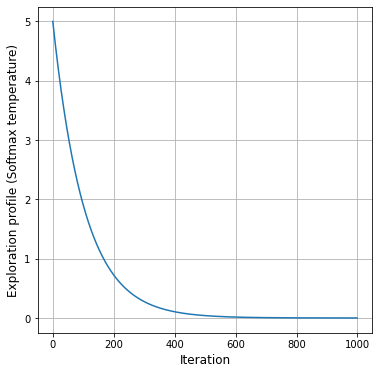

In [ ]:
### Define exploration profile
initial_value = 5
num_iterations = 1000
exp_decay = np.exp(-np.log(initial_value) / num_iterations * 6) # We compute the exponential decay in such a way the shape of the exploration profile does not depend on the number of iterations
exploration_profile = [initial_value * (exp_decay ** i) for i in range(num_iterations)]

### Plot exploration profile
fig = plt.figure(figsize = (6,6) )
plt.plot(exploration_profile)
plt.grid()
plt.xlabel('Iteration', size = 12)
plt.ylabel('Exploration profile (Softmax temperature)', size = 12)
plt.show()
fig.savefig("policy.pdf", transparent = True, bbox_inches = "tight", pad_inches = 0)

# Gym Environment (CartPole-v1)

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.

https://gym.openai.com/envs/CartPole-v1/

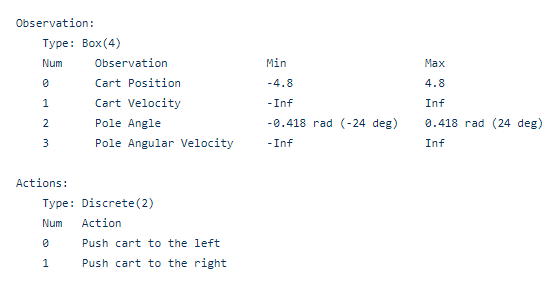

In [ ]:
### Create environment
env = gym.make('CartPole-v1') # Initialize the Gym environment
env.seed(0) # Set a random seed for the environment (reproducible results)

# Get the shapes of the state space (observation_space) and action space (action_space)
state_space_dim = env.observation_space.shape[0]
action_space_dim = env.action_space.n

print(f"STATE SPACE SIZE: {state_space_dim}")
print(f"ACTION SPACE SIZE: {action_space_dim}")

STATE SPACE SIZE: 4
ACTION SPACE SIZE: 2


## Random agent

First of all, to check that the environment is working properly, let's try with an agent which simply choose an action randomly.

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True)

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done and score < 490:
      # Choose a random action
      action = random.choice([0, 1])
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment (optional, comment this line to speed up the simulation)
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 

env.close()


EPISODE 1 - FINAL SCORE: 35.0
EPISODE 2 - FINAL SCORE: 9.0
EPISODE 3 - FINAL SCORE: 29.0
EPISODE 4 - FINAL SCORE: 21.0
EPISODE 5 - FINAL SCORE: 10.0
EPISODE 6 - FINAL SCORE: 14.0
EPISODE 7 - FINAL SCORE: 38.0
EPISODE 8 - FINAL SCORE: 15.0
EPISODE 9 - FINAL SCORE: 60.0
EPISODE 10 - FINAL SCORE: 38.0


In [ ]:
# Display the videos, not required outside Colab
show_videos()

# Network update

## Initialization

In this case we will use the Huber loss as loss function (https://pytorch.org/docs/stable/generated/torch.nn.SmoothL1Loss.html). The Huber loss uses a squared term if the absolute element-wise error falls below beta and an L1 term otherwise. It is less sensitive to outliers than the MSELoss and in some cases prevents exploding gradients.

In [ ]:
# Set random seeds
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

### PARAMETERS
gamma = 0.97   # gamma parameter for the long term reward
replay_memory_capacity = 10000   # Replay memory capacity
lr = 1e-2   # Optimizer learning rate
target_net_update_steps = 10   # Number of episodes to wait before updating the target network
batch_size = 128   # Number of samples to take from the replay memory for each update
bad_state_penalty = 0   # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 
min_samples_for_training = 1000   # Minimum samples in the replay memory to enable the training

In [ ]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.SGD(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

## Update function

In [ ]:
def update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size):
        
    # Sample the data from the replay memory
    batch = replay_mem.sample(batch_size)
    batch_size = len(batch)

    # Create tensors for each element of the batch
    states      = torch.tensor([s[0] for s in batch], dtype=torch.float32)
    actions     = torch.tensor([s[1] for s in batch], dtype=torch.int64)
    rewards     = torch.tensor([s[3] for s in batch], dtype=torch.float32)

    # Compute a mask of non-final states (all the elements where the next state is not None)
    non_final_next_states = torch.tensor([s[2] for s in batch if s[2] is not None], dtype=torch.float32) # the next state can be None if the game has ended
    non_final_mask = torch.tensor([s[2] is not None for s in batch], dtype=torch.bool)

    # Compute all the Q values (forward pass)
    policy_net.train()
    q_values = policy_net(states)
    # Select the proper Q value for the corresponding action taken Q(s_t, a)
    state_action_values = q_values.gather(1, actions.unsqueeze(1))

    # Compute the value function of the next states using the target network V(s_{t+1}) = max_a( Q_target(s_{t+1}, a)) )
    with torch.no_grad():
      target_net.eval()
      q_values_target = target_net(non_final_next_states)
    next_state_max_q_values = torch.zeros(batch_size)
    next_state_max_q_values[non_final_mask] = q_values_target.max(dim=1)[0]

    # Compute the expected Q values
    expected_state_action_values = rewards + (next_state_max_q_values * gamma)
    expected_state_action_values = expected_state_action_values.unsqueeze(1) # Set the required tensor shape

    # Compute the Huber loss
    loss = loss_fn(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    
    # Apply gradient clipping (clip all the gradients greater than 2 for training stability)
    nn.utils.clip_grad_norm_(policy_net.parameters(), 2)
    optimizer.step()

## Training loop (first version - initial)
Reward is not updated

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes

results = []
for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    results.append(score)
env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCO

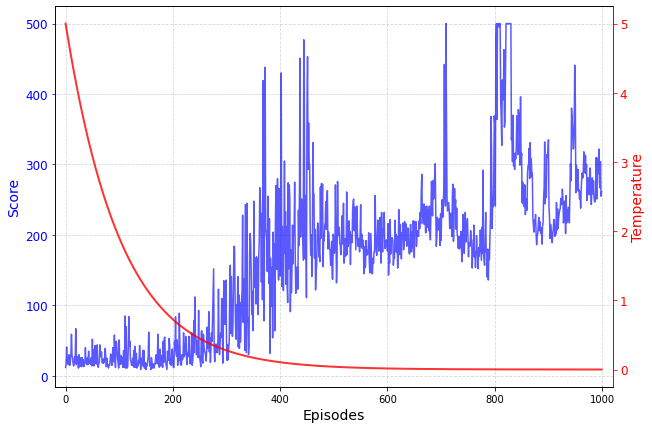

In [ ]:
# PLOTTING THE SCORES

save=True

color1="blue"
color2 = "red"

fig, ax = plt.subplots(figsize = (10,7))
ax.plot(results, color = color1, alpha = 0.65)

ax.set_xlabel("Episodes", size = 14)
ax.set_ylabel("Score", size = 14, color=color1)
ax.set_xlim(-20, len(results)+20)
ax.grid(axis = "both", alpha = 0.5, linestyle = "--")

# coloring left Y-axis
ax.spines['left'].set_color(color1)
ax.tick_params(axis='y', colors=color1, labelsize=12)

# used to overlap 2 plots in the same figure
ax2=ax.twinx()

# make a plot with different y-axis using second axis object
ax2.plot(np.array(exploration_profile) ,color=color2, alpha =0.8, linewidth=2, label="Temperature")
ax2.set_ylabel("Temperature",color=color2,fontsize=14)

# coloring right Y-axis
ax2.spines['right'].set_color(color2)
ax2.tick_params(axis='y', colors=color2, labelsize=12)
plt.show()

if save: fig.savefig("CP_initial_train_score_adv_adapt_lr_0001_g_097_bs128_bsp0_wp1.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
# Display the videos, not required outside Colab
show_videos()

## Training loop (advanced) (LAB class)
Let's modify the reward to improve the results.

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(0) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes
results_adv = []
for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # We apply a (linear) penalty when the cart is far from center
      pos_weight = 1
      reward = reward - pos_weight * np.abs(state[0]) 

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    results_adv.append(score)
env.close()

  0%|          | 0/1000 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 12 - Temperature: 5.0
EPISODE: 2 - FINAL SCORE: 17 - Temperature: 4.951949240166454
EPISODE: 3 - FINAL SCORE: 41 - Temperature: 4.904360255437024
EPISODE: 4 - FINAL SCORE: 19 - Temperature: 4.857228608082785
EPISODE: 5 - FINAL SCORE: 24 - Temperature: 4.810549903022062
EPISODE: 6 - FINAL SCORE: 16 - Temperature: 4.764319787410582
EPISODE: 7 - FINAL SCORE: 30 - Temperature: 4.7185339502355665
EPISODE: 8 - FINAL SCORE: 29 - Temperature: 4.673188121913726
EPISODE: 9 - FINAL SCORE: 15 - Temperature: 4.628278073893115
EPISODE: 10 - FINAL SCORE: 21 - Temperature: 4.583799618258813
Updating target network...
EPISODE: 11 - FINAL SCORE: 31 - Temperature: 4.5397486073424025
EPISODE: 12 - FINAL SCORE: 59 - Temperature: 4.4961209333351855
EPISODE: 13 - FINAL SCORE: 29 - Temperature: 4.452912527905132
EPISODE: 14 - FINAL SCORE: 26 - Temperature: 4.4101193618175
EPISODE: 15 - FINAL SCORE: 18 - Temperature: 4.367737444559107
EPISODE: 16 - FINAL SCO

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  


EPISODE: 44 - FINAL SCORE: 53 - Temperature: 3.300925656226998
EPISODE: 45 - FINAL SCORE: 46 - Temperature: 3.2692032590398465
EPISODE: 46 - FINAL SCORE: 14 - Temperature: 3.237785718910413
EPISODE: 47 - FINAL SCORE: 27 - Temperature: 3.206670106116043
EPISODE: 48 - FINAL SCORE: 20 - Temperature: 3.175853519089164
EPISODE: 49 - FINAL SCORE: 31 - Temperature: 3.145333084146709
EPISODE: 50 - FINAL SCORE: 21 - Temperature: 3.115105955222141
Updating target network...
EPISODE: 51 - FINAL SCORE: 11 - Temperature: 3.0851693136000553
EPISODE: 52 - FINAL SCORE: 35 - Temperature: 3.0555203676533305
EPISODE: 53 - FINAL SCORE: 13 - Temperature: 3.0261563525828072
EPISODE: 54 - FINAL SCORE: 11 - Temperature: 2.9970745301594635
EPISODE: 55 - FINAL SCORE: 22 - Temperature: 2.9682721884690775
EPISODE: 56 - FINAL SCORE: 54 - Temperature: 2.939746641659333
EPISODE: 57 - FINAL SCORE: 44 - Temperature: 2.911495229689364
EPISODE: 58 - FINAL SCORE: 16 - Temperature: 2.8835153180817
EPISODE: 59 - FINAL SCOR

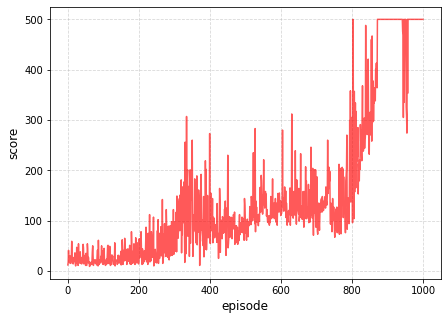

In [ ]:
fig = plt.figure(figsize = (7,5))
plt.plot(results_adv, color = "red", alpha = 0.65)
plt.xlabel("episode", size = 12)
plt.ylabel("score", size = 12)
plt.grid(axis = "both", alpha = 0.5, linestyle = "--")
fig.savefig("train_score.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0)

In [ ]:
# Display the videos, not required outside Colab
show_videos()

## Training loop (Advanced - Homework 3)

In [ ]:
# Set random seeds
torch.manual_seed(2026924)
np.random.seed(2026924)
random.seed(2026924)


### PARAMETERS
gamma = 0.98                      # gamma parameter for the long term reward
lr = 0.001                        # Optimizer learning rate
batch_size = 256                  # Number of samples to take from the replay memory for each update

target_net_update_steps = 20      # Number of episodes to wait before updating the target network
replay_memory_capacity = 10000    # Replay memory capacity

bad_state_penalty = -0.5          # Penalty to the reward when we are in a bad state (in this case when the pole falls down) 

min_samples_for_training = 1000   # min threshold to star the training the network

adaptive_learnig_rate = True      # in order to use adaptive learning rate

In [ ]:
### Initialize the replay memory
replay_mem = ReplayMemory(replay_memory_capacity)    

### Initialize the policy network
policy_net = DQN(state_space_dim, action_space_dim)

### Initialize the target network with the same weights of the policy network
target_net = DQN(state_space_dim, action_space_dim)
target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

### Initialize the optimizer
optimizer = torch.optim.Adam(policy_net.parameters(), lr=lr) # The optimizer will update ONLY the parameters of the policy network

### Initialize the loss function (Huber loss)
loss_fn = nn.SmoothL1Loss()

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(2026924) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: episode_id % 100 == 0) # Save a video every 100 episodes


new_lr_log=lr
results_adv1 = []
for episode_num, tau in enumerate(tqdm(exploration_profile)):

    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False

    # Go on until the pole falls off
    while not done:

      # Choose the action following the policy
      action, q_values = choose_action_softmax(policy_net, state, temperature=tau)
      
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)

      # We apply a (linear) penalty when the cart is far from center
      pos_weight = 2 ###UPDATE FROM 1 TO 1.5
      reward = reward - pos_weight * np.abs(state[0]) 

      # Update the final score (+1 for each step)
      score += 1

      # Apply penalty for bad state
      if done: # if the pole has fallen down 
          reward += bad_state_penalty
          next_state = None

      # Update the replay memory
      replay_mem.push(state, action, next_state, reward)
 

      # Update the network
      if len(replay_mem) > min_samples_for_training: # we enable the training only if we have enough samples in the replay memory, otherwise the training will use the same samples too often
          update_step(policy_net, target_net, replay_mem, gamma, optimizer, loss_fn, batch_size)

      # Visually render the environment (disable to speed up the training)
      #env.render()

      # Set the current state for the next iteration
      state = next_state

    # Update the target network every target_net_update_steps episodes
    if episode_num % target_net_update_steps == 0:
        print('Updating target network...')
        target_net.load_state_dict(policy_net.state_dict()) # This will copy the weights of the policy network to the target network

    # Print the final score
    print(f"EPISODE: {episode_num + 1} - FINAL SCORE: {score} - Temperature: {tau}") # Print the final score
    results_adv1.append(score)

    # EARLY STOPPING stopping
    if all(i == 500 for i in results_adv1[episode_num-10:]): break

      # ADAPTIVE LEARNING RATE
    if adaptive_learnig_rate == True:

      if optimizer.param_groups[0]['lr'] != new_lr_log:
         print("\t\t\t\t\t\t\t\t New Learning rate:", optimizer.param_groups[0]['lr'])

      if optimizer.param_groups[0]['lr'] == lr/20  or results_adv1[-1] >= 400:   #last episodes reach score=400: lr_initial =0.001 --->lr_final = 0.0002
          optimizer.param_groups[0]['lr'] = lr/20
          new_lr_log=lr/20
          

      #elif optimizer.param_groups[0]['lr'] == lr/50 or results_adv1[-1] >= 300:  #last episodes reach score=400: lr_initial =0.1 --->lr_final = 0.001
       #  optimizer.param_groups[0]['lr'] = lr/50

      elif optimizer.param_groups[0]['lr'] == lr/5 or results_adv1[-1] >= 200:   #last episodes reach score=200: lr_initial =0.1 --->lr_final = 0.005
          optimizer.param_groups[0]['lr'] = lr/5
          new_lr_log=lr/5

      elif optimizer.param_groups[0]['lr'] == lr/2 or results_adv1[-1] >= 100:   #last episodes reach score=100: lr_initial =0.1 --->lr_final = 0.01
          optimizer.param_groups[0]['lr'] = lr/2
          new_lr_log=lr/2

#      if episode_num % 100 == 0:
#          print("\t\t\t\t\t\t\t Learning rate:", optimizer.param_groups[0]['lr'])



env.close()

  0%|          | 0/700 [00:00<?, ?it/s]

Updating target network...
EPISODE: 1 - FINAL SCORE: 16 - Temperature: 5.0
								 New Learning rate: 5e-05
EPISODE: 2 - FINAL SCORE: 24 - Temperature: 4.931497676847884
EPISODE: 3 - FINAL SCORE: 47 - Temperature: 4.863933867351216
EPISODE: 4 - FINAL SCORE: 40 - Temperature: 4.797295713436853
EPISODE: 5 - FINAL SCORE: 53 - Temperature: 4.7315705331932305
EPISODE: 6 - FINAL SCORE: 50 - Temperature: 4.666745818456864
EPISODE: 7 - FINAL SCORE: 24 - Temperature: 4.6028092324319205
EPISODE: 8 - FINAL SCORE: 15 - Temperature: 4.539748607342402
EPISODE: 9 - FINAL SCORE: 20 - Temperature: 4.477551942116494
EPISODE: 10 - FINAL SCORE: 15 - Temperature: 4.416207400102644
EPISODE: 11 - FINAL SCORE: 47 - Temperature: 4.355703306816926
EPISODE: 12 - FINAL SCORE: 29 - Temperature: 4.2960281477212625
EPISODE: 13 - FINAL SCORE: 22 - Temperature: 4.2371705660321055
EPISODE: 14 - FINAL SCORE: 14 - Temperature: 4.179119360559112
EPISODE: 15 - FINAL SCORE: 32 - Temperature: 4.121863483573455
EPISODE: 16 -

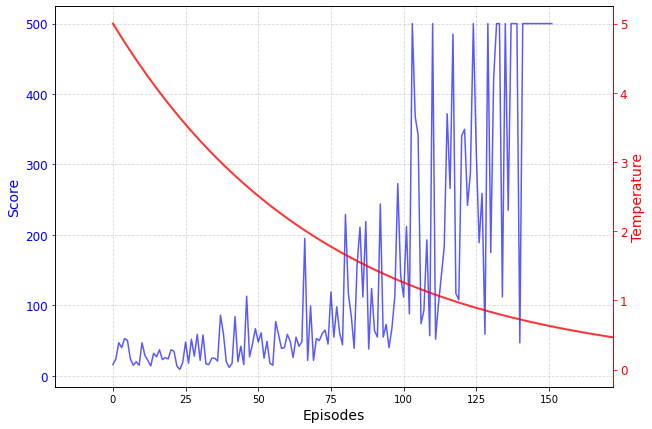

In [ ]:
# PLOTTING THE SCORES

save=False

color1="blue"
color2 = "red"

fig, ax = plt.subplots(figsize = (10,7))
ax.plot(results_adv1, color = color1, alpha = 0.65)

ax.set_xlabel("Episodes", size = 14)
ax.set_ylabel("Score", size = 14, color=color1)
ax.set_xlim(-20, len(results_adv1)+20)
ax.grid(axis = "both", alpha = 0.5, linestyle = "--")

# coloring left Y-axis
ax.spines['left'].set_color(color1)
ax.tick_params(axis='y', colors=color1, labelsize=12)

# used to overlap 2 plots in the same figure
ax2=ax.twinx()

# make a plot with different y-axis using second axis object
ax2.plot(np.array(exploration_profile) ,color=color2, alpha =0.8, linewidth=2, label="Temperature")
ax2.set_ylabel("Temperature",color=color2,fontsize=14)

# coloring right Y-axis
ax2.spines['right'].set_color(color2)
ax2.tick_params(axis='y', colors=color2, labelsize=12)
plt.show()

if save: fig.savefig("CP_train_score_adv_adapt_lr_0001_g_098_bs256_bsp-05_wp2.pdf", transparent = True, bbox_inches = 'tight', pad_inches = 0)

# Final Test for model

In [ ]:
# Initialize the Gym environment
env = gym.make('CartPole-v1') 
env.seed(1) # Set a random seed for the environment (reproducible results)

# This is for creating the output video in Colab, not required outside Colab
env = wrap_env(env, video_callable=lambda episode_id: True) # Save a video every episode

# Let's try for a total of 10 episodes
for num_episode in range(10): 
    # Reset the environment and get the initial state
    state = env.reset()
    # Reset the score. The final score will be the total amount of steps before the pole falls
    score = 0
    done = False
    # Go on until the pole falls off or the score reach 490
    while not done:
      # Choose the best action (temperature 0)
      action, q_values = choose_action_softmax(policy_net, state, temperature=0)
      # Apply the action and get the next state, the reward and a flag "done" that is True if the game is ended
      next_state, reward, done, info = env.step(action)
      # Visually render the environment
      env.render()
      # Update the final score (+1 for each step)
      score += reward 
      # Set the current state for the next iteration
      state = next_state
      # Check if the episode ended (the pole fell down)
    # Print the final score
    print(f"EPISODE {num_episode + 1} - FINAL SCORE: {score}") 
env.close()

EPISODE 1 - FINAL SCORE: 500.0
EPISODE 2 - FINAL SCORE: 500.0
EPISODE 3 - FINAL SCORE: 500.0
EPISODE 4 - FINAL SCORE: 500.0
EPISODE 5 - FINAL SCORE: 500.0
EPISODE 6 - FINAL SCORE: 500.0
EPISODE 7 - FINAL SCORE: 500.0
EPISODE 8 - FINAL SCORE: 500.0
EPISODE 9 - FINAL SCORE: 500.0
EPISODE 10 - FINAL SCORE: 500.0


In [ ]:
# Display the videos, not required outside Colab
show_videos()


SHOWING VIDEO video/openaigym.video.2.31041.video000000.mp4



SHOWING VIDEO video/openaigym.video.2.31041.video000001.mp4



SHOWING VIDEO video/openaigym.video.2.31041.video000002.mp4



SHOWING VIDEO video/openaigym.video.2.31041.video000003.mp4



SHOWING VIDEO video/openaigym.video.2.31041.video000004.mp4



SHOWING VIDEO video/openaigym.video.2.31041.video000005.mp4



SHOWING VIDEO video/openaigym.video.2.31041.video000006.mp4



SHOWING VIDEO video/openaigym.video.2.31041.video000007.mp4



SHOWING VIDEO video/openaigym.video.2.31041.video000008.mp4



SHOWING VIDEO video/openaigym.video.2.31041.video000009.mp4
